<a href="https://colab.research.google.com/github/Chubbyman2/Stock_Predictor/blob/master/Stock_Predictor_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# Goal: Use an LSTM neural network to predict the closing stock price of a corporation
# Uses closing prices of past 60 days to predict next day's

In [56]:
import math
import datetime
import pytz
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [57]:
# Convert timezone to EST
est = pytz.timezone("US/Eastern")
timezone = timezone.astimezone(est)
today = timezone.strftime("%Y-%m-%d")

# Stock quote
stock_name = "IBM"
df = web.DataReader(stock_name, data_source="yahoo", start="2015-01-01", end=today)

In [58]:
# New datagrame with only "Close" column
data = df.filter(["Close"])
dataset = data.values # convert to numpy array
training_data_len = math.ceil(len(dataset)*.8) # Training 80%, Validation 20%

In [59]:
# Scale data between 0 and 1, inclusive
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [60]:
# Create training dataset, scale
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [61]:
# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(1089, 60)

In [62]:
# Reshape data to 3 dimensions - (num_samples, num_time_steps, num_features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [63]:
# LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

In [64]:
# Compile
model.compile(optimizer="adam", loss="mean_squared_error")

# Train
model.fit(x_train, y_train, batch_size=1, epochs=1)

1089/1089 [==============================] - 7s 7ms/step - loss: 0.0046


In [65]:
# Validation dataset
val_data = scaled_data[training_data_len - 60:, :]

x_val = []
y_val = dataset[training_data_len:, :] # The final 20%

for i in range(60, len(val_data)):
  x_val.append(val_data[i-60:i, 0])

In [66]:
# Convert to numpy array, reshape
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

In [67]:
# Get predicted values, unscale
predictions = model.predict(x_val)
predictions = scaler.inverse_transform(predictions)

In [68]:
# Measure loss using root mean squared error 
# Compares predictions to y_val
rmse = np.sqrt(np.mean(((predictions - y_val)**2)))
rmse

4.517554129414407

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


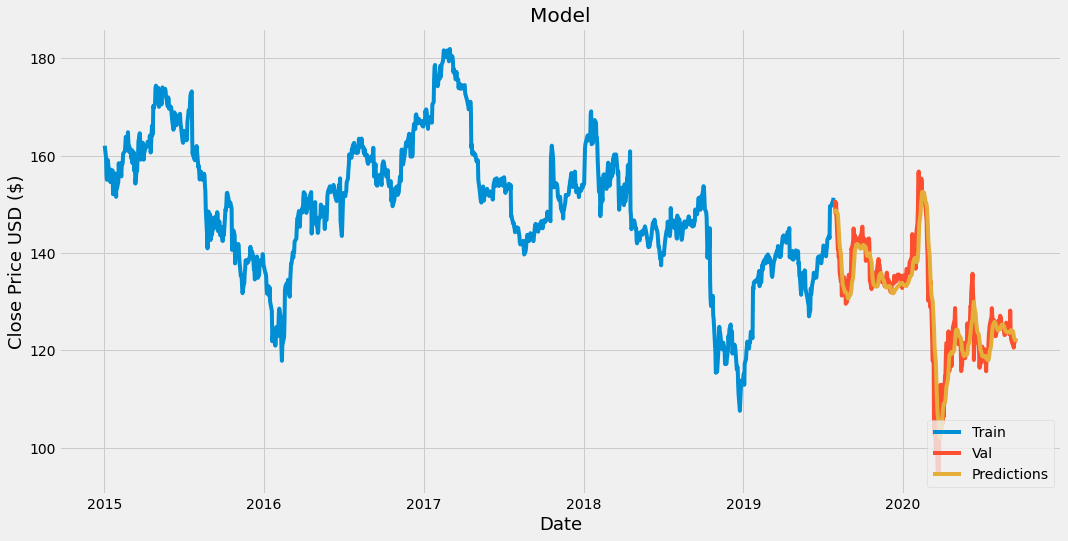

In [69]:
# Plot data
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions

plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()

In [70]:
# Display predictions vs validation set
valid

,Close,Predictions
Date,,
2019-07-29,150.880005,148.111603
2019-07-30,149.770004,148.598099
2019-07-31,148.240005,148.778000
2019-08-01,150.320007,148.581879
2019-08-02,147.250000,148.462067
...,...,...
2020-09-09,122.260002,123.548553
2020-09-10,120.559998,123.108322
2020-09-11,121.459999,122.536316


In [71]:
def predict_price(stock_quote):
  # Create new dataframe
  new_df = stock_quote.filter(["Close"])

  # Get last 60 days' closing prices
  # Convert dataframe to array, scale
  past_60 = new_df[-60:].values
  past_60_scaled = scaler.transform(past_60)

  # Create new array for actual testing
  X_test = []
  X_test.append(past_60_scaled)

  # Convert to array, reshape
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  # Get prediction, unscale
  pred_price = model.predict(X_test)
  pred_price = scaler.inverse_transform(pred_price)
  return pred_price

print(predict_price(df))

[[121.59296]]


In [75]:
# Compare to actual price
quote = web.DataReader(stock_name, data_source="yahoo", start=today, end=today)
quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-09-15,123.400002,122.239998,122.82,122.440002,2913192,122.440002
2020-09-15,123.400002,122.239998,122.82,122.440002,2914000,122.440002
